In [1]:
import sys
import os
import os.path as path

import random
from scipy.stats import beta
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

sys.path.insert(1, path.join(path.abspath(path.pardir)))
import sims

## Load datasets

In [2]:
# load probabilities
df = pd.read_csv("new_graph.csv")

In [15]:
df[['User', 'Group1']].drop_duplicates().groupby('Group1').count()

,User
Group1,
A,69
B,230


In [4]:
nodes.groupby('Group').count()

,Id,Label
Group,,
A,71,71
B,244,244


## Propagation of the articles

In [94]:
# GLOBAL VARIABLES
TRIALS = 20
T      = 10
M      = 69

In [105]:
# UTIL METHODS

## plotting
def plot(df):
    '''Plot the lines in the dataframe.'''
    return sns.lineplot(x='t', y='n', data=df)


def plotgen(g):
    '''Plot the dataframe built from the generator.'''
    df = pd.DataFrame(g, columns=['t', 'n'])
    return plot(df)


## experiments
def remove_determinism(seed):
    '''Fix the seed of the prngs.'''
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


## other
def filter_list(l, blacklist=[]):
    '''Filter out from a list the elements in `blacklist`.'''
    return [e for e in l if e not in blacklist]

### Propagation with the model

In [96]:
# model parameters
theta_opt = {1: 4.316992360088821e-11,
             -1: 0.9999999999745947}
pi, beta_dist, P, v, c, q = sims.get_params('twitter_uselections')
params = theta_opt, T, pi, M, P, beta_dist, v, c, q

In [97]:
# run unconstrained simulations
players_list_opt = [a + [0] * (T - len(a))
                        for a in [sims.runModel(*params)[0]
                                for i in range(TRIALS)]]

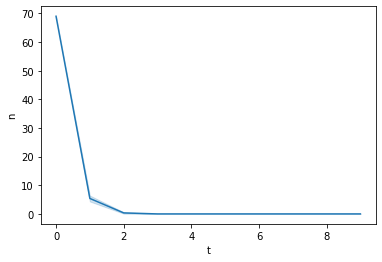

In [98]:
# plot results
plot(pd.DataFrame({'t': [i for _ in range(TRIALS) for i in range(T)],
                   'n': np.array(players_list_opt).reshape(-1)}))
plt.show()

### Propagation with the labeled network

In [99]:
def num_players(G):
    return len(G.User.unique())


def sample_seeds(df, group, size):
    '''Return dataframe with a random sample of users.'''
    # sample `size` users as the first set of users to see the article
    # we need to drop duplicates as we have a row for each (user, follower) pair
    seeds = (df[['User', 'Group1']].drop_duplicates()
                                   .query(f'Group1 == "{group}"')
                                   .sample(size)
                                   .User)
    # take the rows of the seed users
    G = df[df.User.isin(seeds)]
    return G


def propagate(df, group='A', article='Pa', steps=T, size=M, seed=0, func=num_players):
    '''Evaluates a function on each step of the propagation of an article through the network.'''
    remove_determinism(seed)
    G = sample_seeds(df, group, size)
    for i in range(steps):
        yield i, func(G)
        
        # toss a coin for each exposed user to determine whether or not they will share the article
        shared = np.random.binomial(1, p=G[article])
        
        # get the followers that are not part of the preivous generation
        newG = G[shared.astype(bool)].Follower.unique()
        newG = filter_list(newG, blacklist=G.User.tolist())
        G = df[df.User.isin(newG)]

In [100]:
def repeat_propagation(df, trials, **kwargs):
    for trial in range(trials):
        for result in propagate(df, seed=trial, **kwargs):
            yield result

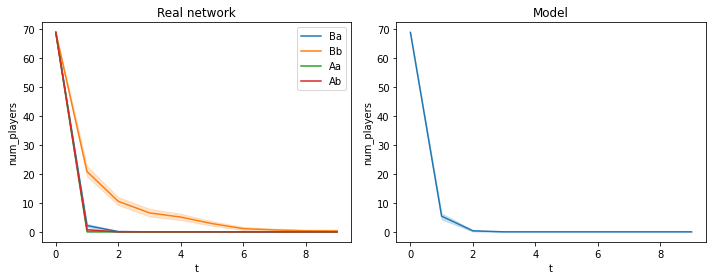

In [117]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plotgen(repeat_propagation(df, TRIALS, group='B', article='Pa'))
plotgen(repeat_propagation(df, TRIALS, group='B', article='Pb'))
plotgen(repeat_propagation(df, TRIALS, group='A', article='Pa'))
g = plotgen(repeat_propagation(df, TRIALS, group='A', article='Pb'))

#g.set_yscale("log")
#g.set_xscale("log")
g.legend(['Ba', 'Bb', 'Aa', 'Ab'])
g.set(ylabel='num_players')
g.set_title('Real network')
#plt.savefig('uselections.png', format='png', dpi=1200)

# plot model results
plt.subplot(1, 2, 2)
g = plot(pd.DataFrame({'t': [i for _ in range(TRIALS) for i in range(T)],
                       'n': np.array(players_list_opt).reshape(-1)}))
g.set(ylabel='num_players')
g.set_title('Model')
plt.tight_layout()
plt.show()